# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)

### List of interacting proteins (according to STRING and Uniprot)

In [4]:
#Build the protein list; this may have only a single protein if desired
#protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins

### Test for phosphorylation levels (difference between cancer wildtype and normal wildtype

In [5]:
#List of proteins (will test all phosphorylation sites on these proteins (all proteins) )
phosProtList = protList

In [6]:
sites = phos.columns
p_values = []
p_values_wt_vs_mut_canc = []
site_names = []
gene = 'PIK3CA'

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene).dropna(axis=0)
        for site in phosphositesdf.columns:
            '''just making sure not to do comparison on mutation column or patient_type column'''
            if (site is not 'Mutation' and site is not 'Patient_Type'):
                sitedf = CPTAC.compare_mutations(phos, site, gene).dropna(axis=0)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                '''Split the wildtype datafram into two, cancer wt vs normal wt'''
                cancer_wtdf = wtdf.loc[wtdf['Patient_Type'] == "Tumor"].dropna(axis=0)
                normal_wtdf = wtdf.loc[wtdf['Patient_Type'] == "Normal"].dropna(axis=0)
                '''We do our t-test on these two datframes, comparing phosphorylation levels in cancer wt with normal wt'''
                ttest = scipy.stats.ttest_ind(cancer_wtdf[site], normal_wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)
                '''Do a second t-test to compare cancer mutation vs. cancer wildtype'''
                ttest_wt_v_mut_canc = scipy.stats.ttest_ind(mutateddf[site], cancer_wtdf[site])
                p_values_wt_vs_mut_canc.append(ttest_wt_v_mut_canc[1])


#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)
    if np.isnan(p_values_wt_vs_mut_canc[index]):
        indexesToRemove.append(index)
        
indexesToRemove = list(set(indexesToRemove))
indexesToRemove.sort()

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    p_values_wt_vs_mut_canc.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])

#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)
print(p_values_wt_vs_mut_canc)  

print(len(p_values))
print(len(p_values_wt_vs_mut_canc))
print(len(site_names))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Seeing significance of P values using bonferroni correction

In [7]:
'''Account for multiple testing by adjusting the threshold p-value according to how many sites we tested (bonferroni correction)'''
threshold_pval = .05/len(site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_corrected_mutated_vs_cancwt_pvals = list()
bonferonni_sig_sites = list()
'''Add all the sites and p-values of the p-values that met our new threshold'''
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval and p_values_wt_vs_mut_canc[ind] <= .01:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_corrected_mutated_vs_cancwt_pvals.append(p_values_wt_vs_mut_canc[ind])
        bonferonni_sig_sites.append(site_names[ind])
        
        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  5.095645261559472e-07


### Print signifcant site names and p-values

In [8]:
for key in sorted(bf_significant_vals):
    print(key, bf_significant_vals[key])

print(len(bonferonni_sig_sites))
print(len(bonferonni_corrected_pvals))
print(len(site_names))
print("\nBF mutated v canc. wt: ", bonferonni_corrected_mutated_vs_cancwt_pvals)

ARMC9-T702 4.366652378664214e-07
DENND4C-S1274 6.557475738571725e-09
DOCK7-S452 6.044916631209498e-10
EDRF1-T632 1.4802021269938788e-07
ERCC6-S489 3.147350759093547e-11
JDP2-S156 4.29945387910923e-07
PCIF1-S146 2.718183958257417e-08
RBBP8NL-S251 2.3232185695933643e-13
RETREG3-T283 2.1777966662198702e-08
14
14
98123

BF mutated v canc. wt:  [0.006932290635537653, 0.006932290635537653, 0.008169518405087152, 0.006932290635537653, 0.0019912575344669028, 0.004308033164506509, 0.008090578820873032, 0.008169518405087152, 0.009977421171462898, 0.00931143836777792, 0.00931143836777792, 0.0060789822299720225, 0.0060789822299720225, 0.009699946337519237]


### Use FDR Correction

In [9]:
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]
significant_vals = dict(zip(significant_sites, significant_pvalues))

print("\nSignificant values (FDR): ", significant_vals)

print(len(significant_sites))


Significant values (FDR):  {'AAAS-S495': 0.010548893442249477, 'AAAS-S541': 0.02861163367174027, 'AAED1-S12': 0.005710954361427741, 'AAK1-S637': 1.9236144121068687e-07, 'AAK1-S676': 0.0021794010145006148, 'AAK1-S682': 0.02657012157248404, 'AAK1-S731': 9.099580962786913e-06, 'AAK1-S846': 0.001971545343916432, 'AAK1-T389': 0.013551113178155098, 'AAK1-T694': 0.006445183911738415, 'AAMDC-S46': 4.8985765234523075e-08, 'AARS-S555': 0.013708067287586242, 'AATF-S316': 0.0029579352001575117, 'AATF-S320': 1.4550779930950421e-05, 'AATF-S321': 5.474996238502193e-05, 'ABCB1-S741': 0.00243509263498554, 'ABCC1-S915': 0.01782734160398106, 'ABCC1-S918': 9.231841074520101e-06, 'ABCC1-S919': 1.791388028201835e-08, 'ABCC1-S921': 4.4257095428505484e-05, 'ABCC1-S930': 0.0002218331176195231, 'ABCC1-T931': 0.006999728427713059, 'ABCC1-Y920': 0.0008891235759949884, 'ABCC3-S884': 0.02372330691730554, 'ABCC3-T890': 0.03254933661496556, 'ABCC4-S665': 0.00964294976819905, 'ABCC4-T646': 5.6471482421967615e-06, 'AB

### Plot phosphorylation levels and gene mutation

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Mutation and Patient Type')]

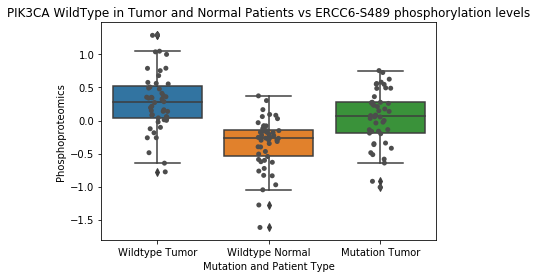

In [12]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

gene = 'PIK3CA'

site="ERCC6-S489"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)

'''First get all the instances where mutation != wildtype'''
mutationdf = genedf.loc[genedf['Mutation'] != 'Wildtype'].drop('Mutation', axis = 1).dropna(axis=0)

'''Get all wildtype cases, change name of patient type to wildtype tumor or wildtype normal depending on patienttype'''
genedf = genedf.loc[genedf['Mutation'] == 'Wildtype'].drop('Mutation', axis = 1).dropna(axis=0)
for i, row in genedf.iterrows():
    id = i
    if row['Patient_Type'] == 'Tumor':
        genedf.set_value(id,'Patient_Type','Wildtype Tumor')
    if row['Patient_Type'] == 'Normal':
        genedf.set_value(id,'Patient_Type','Wildtype Normal')

'''Change name of patient type in mutationdf to mutation tumor'''        
for i, row in mutationdf.iterrows():
    id = i
    mutationdf.set_value(id,'Patient_Type','Mutation Tumor')

'''Merge the two dataframes'''
frames = [genedf, mutationdf]
merged = pd.concat(frames)

'''Plot the data, comparing wildtype cancer, wildtype normal, and mutated cancer'''
phos_boxplot = sns.boxplot(data=merged, x="Patient_Type",y=site)
phos_boxplot.set_title(gene + " WildType in Tumor and Normal Patients vs " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=merged, x="Patient_Type", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation and Patient Type",ylabel="Phosphoproteomics")
